# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 5791744/11490434 [==============>...............] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:46 - loss: 0.6942

  35/1875 [..............................] - ETA: 2s - loss: 0.5254   

  67/1875 [>.............................] - ETA: 2s - loss: 0.4511

 100/1875 [>.............................] - ETA: 2s - loss: 0.4107

 136/1875 [=>............................] - ETA: 2s - loss: 0.3828

 165/1875 [=>............................] - ETA: 2s - loss: 0.3664

 192/1875 [==>...........................] - ETA: 2s - loss: 0.3540

 221/1875 [==>...........................] - ETA: 2s - loss: 0.3428

 252/1875 [===>..........................] - ETA: 2s - loss: 0.3325

 285/1875 [===>..........................] - ETA: 2s - loss: 0.3231

 315/1875 [====>.........................] - ETA: 2s - loss: 0.3156

 347/1875 [====>.........................] - ETA: 2s - loss: 0.3084

 378/1875 [=====>........................] - ETA: 2s - loss: 0.3022

 410/1875 [=====>........................] - ETA: 2s - loss: 0.2963

 441/1875 [======>.......................] - ETA: 2s - loss: 0.2911

 472/1875 [======>.......................] - ETA: 2s - loss: 0.2864

 497/1875 [======>.......................] - ETA: 2s - loss: 0.2828

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2801

 545/1875 [=======>......................] - ETA: 2s - loss: 0.2765

 574/1875 [========>.....................] - ETA: 2s - loss: 0.2730

 599/1875 [========>.....................] - ETA: 2s - loss: 0.2701

 621/1875 [========>.....................] - ETA: 2s - loss: 0.2677

 647/1875 [=========>....................] - ETA: 2s - loss: 0.2650

 674/1875 [=========>....................] - ETA: 2s - loss: 0.2623

 703/1875 [==========>...................] - ETA: 2s - loss: 0.2595

 728/1875 [==========>...................] - ETA: 2s - loss: 0.2572

 755/1875 [===========>..................] - ETA: 1s - loss: 0.2549

 786/1875 [===========>..................] - ETA: 1s - loss: 0.2523

 815/1875 [============>.................] - ETA: 1s - loss: 0.2500

 846/1875 [============>.................] - ETA: 1s - loss: 0.2477

 877/1875 [=============>................] - ETA: 1s - loss: 0.2454

 909/1875 [=============>................] - ETA: 1s - loss: 0.2432

 942/1875 [==============>...............] - ETA: 1s - loss: 0.2410

 975/1875 [==============>...............] - ETA: 1s - loss: 0.2389

1010/1875 [===============>..............] - ETA: 1s - loss: 0.2367

1045/1875 [===============>..............] - ETA: 1s - loss: 0.2347

1082/1875 [================>.............] - ETA: 1s - loss: 0.2326

1119/1875 [================>.............] - ETA: 1s - loss: 0.2306

1158/1875 [=================>............] - ETA: 1s - loss: 0.2285

1195/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1227/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1259/1875 [===================>..........] - ETA: 1s - loss: 0.2237

1293/1875 [===================>..........] - ETA: 0s - loss: 0.2221

1319/1875 [====================>.........] - ETA: 0s - loss: 0.2210

1349/1875 [====================>.........] - ETA: 0s - loss: 0.2197

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2187

1402/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2164

1463/1875 [======================>.......] - ETA: 0s - loss: 0.2151

1494/1875 [======================>.......] - ETA: 0s - loss: 0.2140

1525/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1556/1875 [=======================>......] - ETA: 0s - loss: 0.2117

1589/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1620/1875 [========================>.....] - ETA: 0s - loss: 0.2095

1652/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1684/1875 [=========================>....] - ETA: 0s - loss: 0.2074

1716/1875 [==========================>...] - ETA: 0s - loss: 0.2064

1749/1875 [==========================>...] - ETA: 0s - loss: 0.2054

1781/1875 [===========================>..] - ETA: 0s - loss: 0.2044

1813/1875 [============================>.] - ETA: 0s - loss: 0.2035

1845/1875 [============================>.] - ETA: 0s - loss: 0.2025

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2017


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1124

  32/1875 [..............................] - ETA: 2s - loss: 0.1107

  63/1875 [>.............................] - ETA: 2s - loss: 0.1102

  95/1875 [>.............................] - ETA: 2s - loss: 0.1099

 126/1875 [=>............................] - ETA: 2s - loss: 0.1098

 157/1875 [=>............................] - ETA: 2s - loss: 0.1098

 189/1875 [==>...........................] - ETA: 2s - loss: 0.1098

 220/1875 [==>...........................] - ETA: 2s - loss: 0.1097

 252/1875 [===>..........................] - ETA: 2s - loss: 0.1096

 284/1875 [===>..........................] - ETA: 2s - loss: 0.1095

 316/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 345/1875 [====>.........................] - ETA: 2s - loss: 0.1094

 370/1875 [====>.........................] - ETA: 2s - loss: 0.1093

 392/1875 [=====>........................] - ETA: 2s - loss: 0.1092

 417/1875 [=====>........................] - ETA: 2s - loss: 0.1091

 450/1875 [======>.......................] - ETA: 2s - loss: 0.1090

 478/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 504/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 534/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 564/1875 [========>.....................] - ETA: 2s - loss: 0.1087

 593/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 623/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 652/1875 [=========>....................] - ETA: 2s - loss: 0.1084

 681/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 710/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 740/1875 [==========>...................] - ETA: 1s - loss: 0.1082

 769/1875 [===========>..................] - ETA: 1s - loss: 0.1081

 800/1875 [===========>..................] - ETA: 1s - loss: 0.1080

 830/1875 [============>.................] - ETA: 1s - loss: 0.1079

 860/1875 [============>.................] - ETA: 1s - loss: 0.1078

 889/1875 [=============>................] - ETA: 1s - loss: 0.1078

 919/1875 [=============>................] - ETA: 1s - loss: 0.1077

 950/1875 [==============>...............] - ETA: 1s - loss: 0.1076

 980/1875 [==============>...............] - ETA: 1s - loss: 0.1075

1009/1875 [===============>..............] - ETA: 1s - loss: 0.1075

1039/1875 [===============>..............] - ETA: 1s - loss: 0.1074

1069/1875 [================>.............] - ETA: 1s - loss: 0.1073

1099/1875 [================>.............] - ETA: 1s - loss: 0.1073

1129/1875 [=================>............] - ETA: 1s - loss: 0.1072

1159/1875 [=================>............] - ETA: 1s - loss: 0.1071

1189/1875 [==================>...........] - ETA: 1s - loss: 0.1071

1220/1875 [==================>...........] - ETA: 1s - loss: 0.1070

1251/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1282/1875 [===================>..........] - ETA: 1s - loss: 0.1069

1313/1875 [====================>.........] - ETA: 0s - loss: 0.1068

1344/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1374/1875 [====================>.........] - ETA: 0s - loss: 0.1067

1406/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1437/1875 [=====================>........] - ETA: 0s - loss: 0.1066

1469/1875 [======================>.......] - ETA: 0s - loss: 0.1065

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1064

1555/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1585/1875 [========================>.....] - ETA: 0s - loss: 0.1063

1616/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1648/1875 [=========================>....] - ETA: 0s - loss: 0.1062

1675/1875 [=========================>....] - ETA: 0s - loss: 0.1061

1708/1875 [==========================>...] - ETA: 0s - loss: 0.1061

1738/1875 [==========================>...] - ETA: 0s - loss: 0.1060

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1799/1875 [===========================>..] - ETA: 0s - loss: 0.1059

1830/1875 [============================>.] - ETA: 0s - loss: 0.1058

1860/1875 [============================>.] - ETA: 0s - loss: 0.1058

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1058


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0963

  33/1875 [..............................] - ETA: 2s - loss: 0.0979

  64/1875 [>.............................] - ETA: 2s - loss: 0.0982

  96/1875 [>.............................] - ETA: 2s - loss: 0.0983

 126/1875 [=>............................] - ETA: 2s - loss: 0.0983

 157/1875 [=>............................] - ETA: 2s - loss: 0.0982

 189/1875 [==>...........................] - ETA: 2s - loss: 0.0981

 221/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0979

 285/1875 [===>..........................] - ETA: 2s - loss: 0.0978

 317/1875 [====>.........................] - ETA: 2s - loss: 0.0978

 349/1875 [====>.........................] - ETA: 2s - loss: 0.0977

 380/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 412/1875 [=====>........................] - ETA: 2s - loss: 0.0977

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 594/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 625/1875 [=========>....................] - ETA: 2s - loss: 0.0976

 656/1875 [=========>....................] - ETA: 1s - loss: 0.0975

 688/1875 [==========>...................] - ETA: 1s - loss: 0.0975

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0975

 751/1875 [===========>..................] - ETA: 1s - loss: 0.0975

 783/1875 [===========>..................] - ETA: 1s - loss: 0.0975

 815/1875 [============>.................] - ETA: 1s - loss: 0.0975

 845/1875 [============>.................] - ETA: 1s - loss: 0.0975

 873/1875 [============>.................] - ETA: 1s - loss: 0.0975

 899/1875 [=============>................] - ETA: 1s - loss: 0.0975

 929/1875 [=============>................] - ETA: 1s - loss: 0.0975

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1012/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1073/1875 [================>.............] - ETA: 1s - loss: 0.0975

1104/1875 [================>.............] - ETA: 1s - loss: 0.0975

1134/1875 [=================>............] - ETA: 1s - loss: 0.0975

1164/1875 [=================>............] - ETA: 1s - loss: 0.0975

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1255/1875 [===================>..........] - ETA: 1s - loss: 0.0975

1286/1875 [===================>..........] - ETA: 0s - loss: 0.0975

1315/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1346/1875 [====================>.........] - ETA: 0s - loss: 0.0975

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1407/1875 [=====================>........] - ETA: 0s - loss: 0.0975

1439/1875 [======================>.......] - ETA: 0s - loss: 0.0975

1467/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1497/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1527/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1722/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1818/1875 [============================>.] - ETA: 0s - loss: 0.0974

1850/1875 [============================>.] - ETA: 0s - loss: 0.0974

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0974


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0986

  38/1875 [..............................] - ETA: 2s - loss: 0.0982

  68/1875 [>.............................] - ETA: 2s - loss: 0.0975

 100/1875 [>.............................] - ETA: 2s - loss: 0.0972

 128/1875 [=>............................] - ETA: 2s - loss: 0.0970

 152/1875 [=>............................] - ETA: 2s - loss: 0.0969

 183/1875 [=>............................] - ETA: 2s - loss: 0.0967

 213/1875 [==>...........................] - ETA: 2s - loss: 0.0966

 242/1875 [==>...........................] - ETA: 2s - loss: 0.0965

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0965

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 382/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 415/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 544/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 579/1875 [========>.....................] - ETA: 2s - loss: 0.0962

 613/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 648/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 686/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 719/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 750/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 782/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 812/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 843/1875 [============>.................] - ETA: 1s - loss: 0.0961

 875/1875 [=============>................] - ETA: 1s - loss: 0.0961

 910/1875 [=============>................] - ETA: 1s - loss: 0.0961

 942/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1032/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1062/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1091/1875 [================>.............] - ETA: 1s - loss: 0.0961

1119/1875 [================>.............] - ETA: 1s - loss: 0.0961

1150/1875 [=================>............] - ETA: 1s - loss: 0.0960

1181/1875 [=================>............] - ETA: 1s - loss: 0.0960

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1274/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1303/1875 [===================>..........] - ETA: 0s - loss: 0.0960

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1359/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1523/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1552/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0959

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0959

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0959

1753/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1815/1875 [============================>.] - ETA: 0s - loss: 0.0959

1852/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.1043

  33/1875 [..............................] - ETA: 2s - loss: 0.0979

  66/1875 [>.............................] - ETA: 2s - loss: 0.0969

  97/1875 [>.............................] - ETA: 2s - loss: 0.0966

 122/1875 [>.............................] - ETA: 2s - loss: 0.0964

 146/1875 [=>............................] - ETA: 3s - loss: 0.0963

 175/1875 [=>............................] - ETA: 2s - loss: 0.0962

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0961

 232/1875 [==>...........................] - ETA: 2s - loss: 0.0960

 260/1875 [===>..........................] - ETA: 2s - loss: 0.0960

 288/1875 [===>..........................] - ETA: 2s - loss: 0.0959

 315/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 401/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 430/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 499/1875 [======>.......................] - ETA: 2s - loss: 0.0957

 527/1875 [=======>......................] - ETA: 2s - loss: 0.0957

 564/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0957

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0957

 679/1875 [=========>....................] - ETA: 1s - loss: 0.0957

 713/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 748/1875 [==========>...................] - ETA: 1s - loss: 0.0956

 781/1875 [===========>..................] - ETA: 1s - loss: 0.0956

 820/1875 [============>.................] - ETA: 1s - loss: 0.0956

 846/1875 [============>.................] - ETA: 1s - loss: 0.0956

 879/1875 [=============>................] - ETA: 1s - loss: 0.0956

 911/1875 [=============>................] - ETA: 1s - loss: 0.0956

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 976/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1075/1875 [================>.............] - ETA: 1s - loss: 0.0955

1105/1875 [================>.............] - ETA: 1s - loss: 0.0955

1135/1875 [=================>............] - ETA: 1s - loss: 0.0955

1170/1875 [=================>............] - ETA: 1s - loss: 0.0955

1202/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1258/1875 [===================>..........] - ETA: 0s - loss: 0.0955

1286/1875 [===================>..........] - ETA: 0s - loss: 0.0955

1317/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0955

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1413/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1757/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1826/1875 [============================>.] - ETA: 0s - loss: 0.0954

1864/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

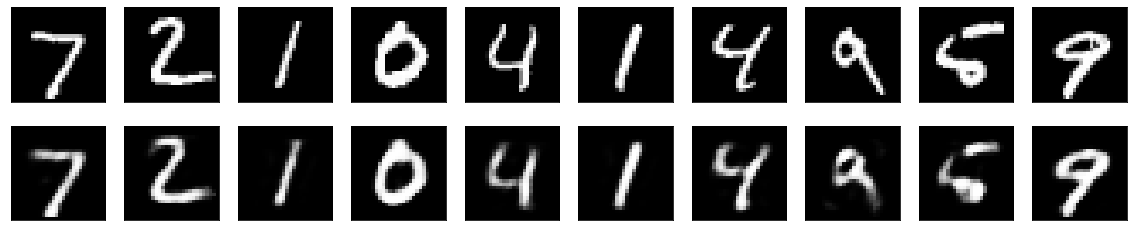

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
